In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
import numpy as np
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from keras.models import load_model
import os
from os.path import isdir
from os import listdir

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from PIL import Image
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN
print(mtcnn.__version__)

     ---------------------------------------- 2.3/2.3 MB 2.2 MB/s eta 0:00:00
0.1.0



[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


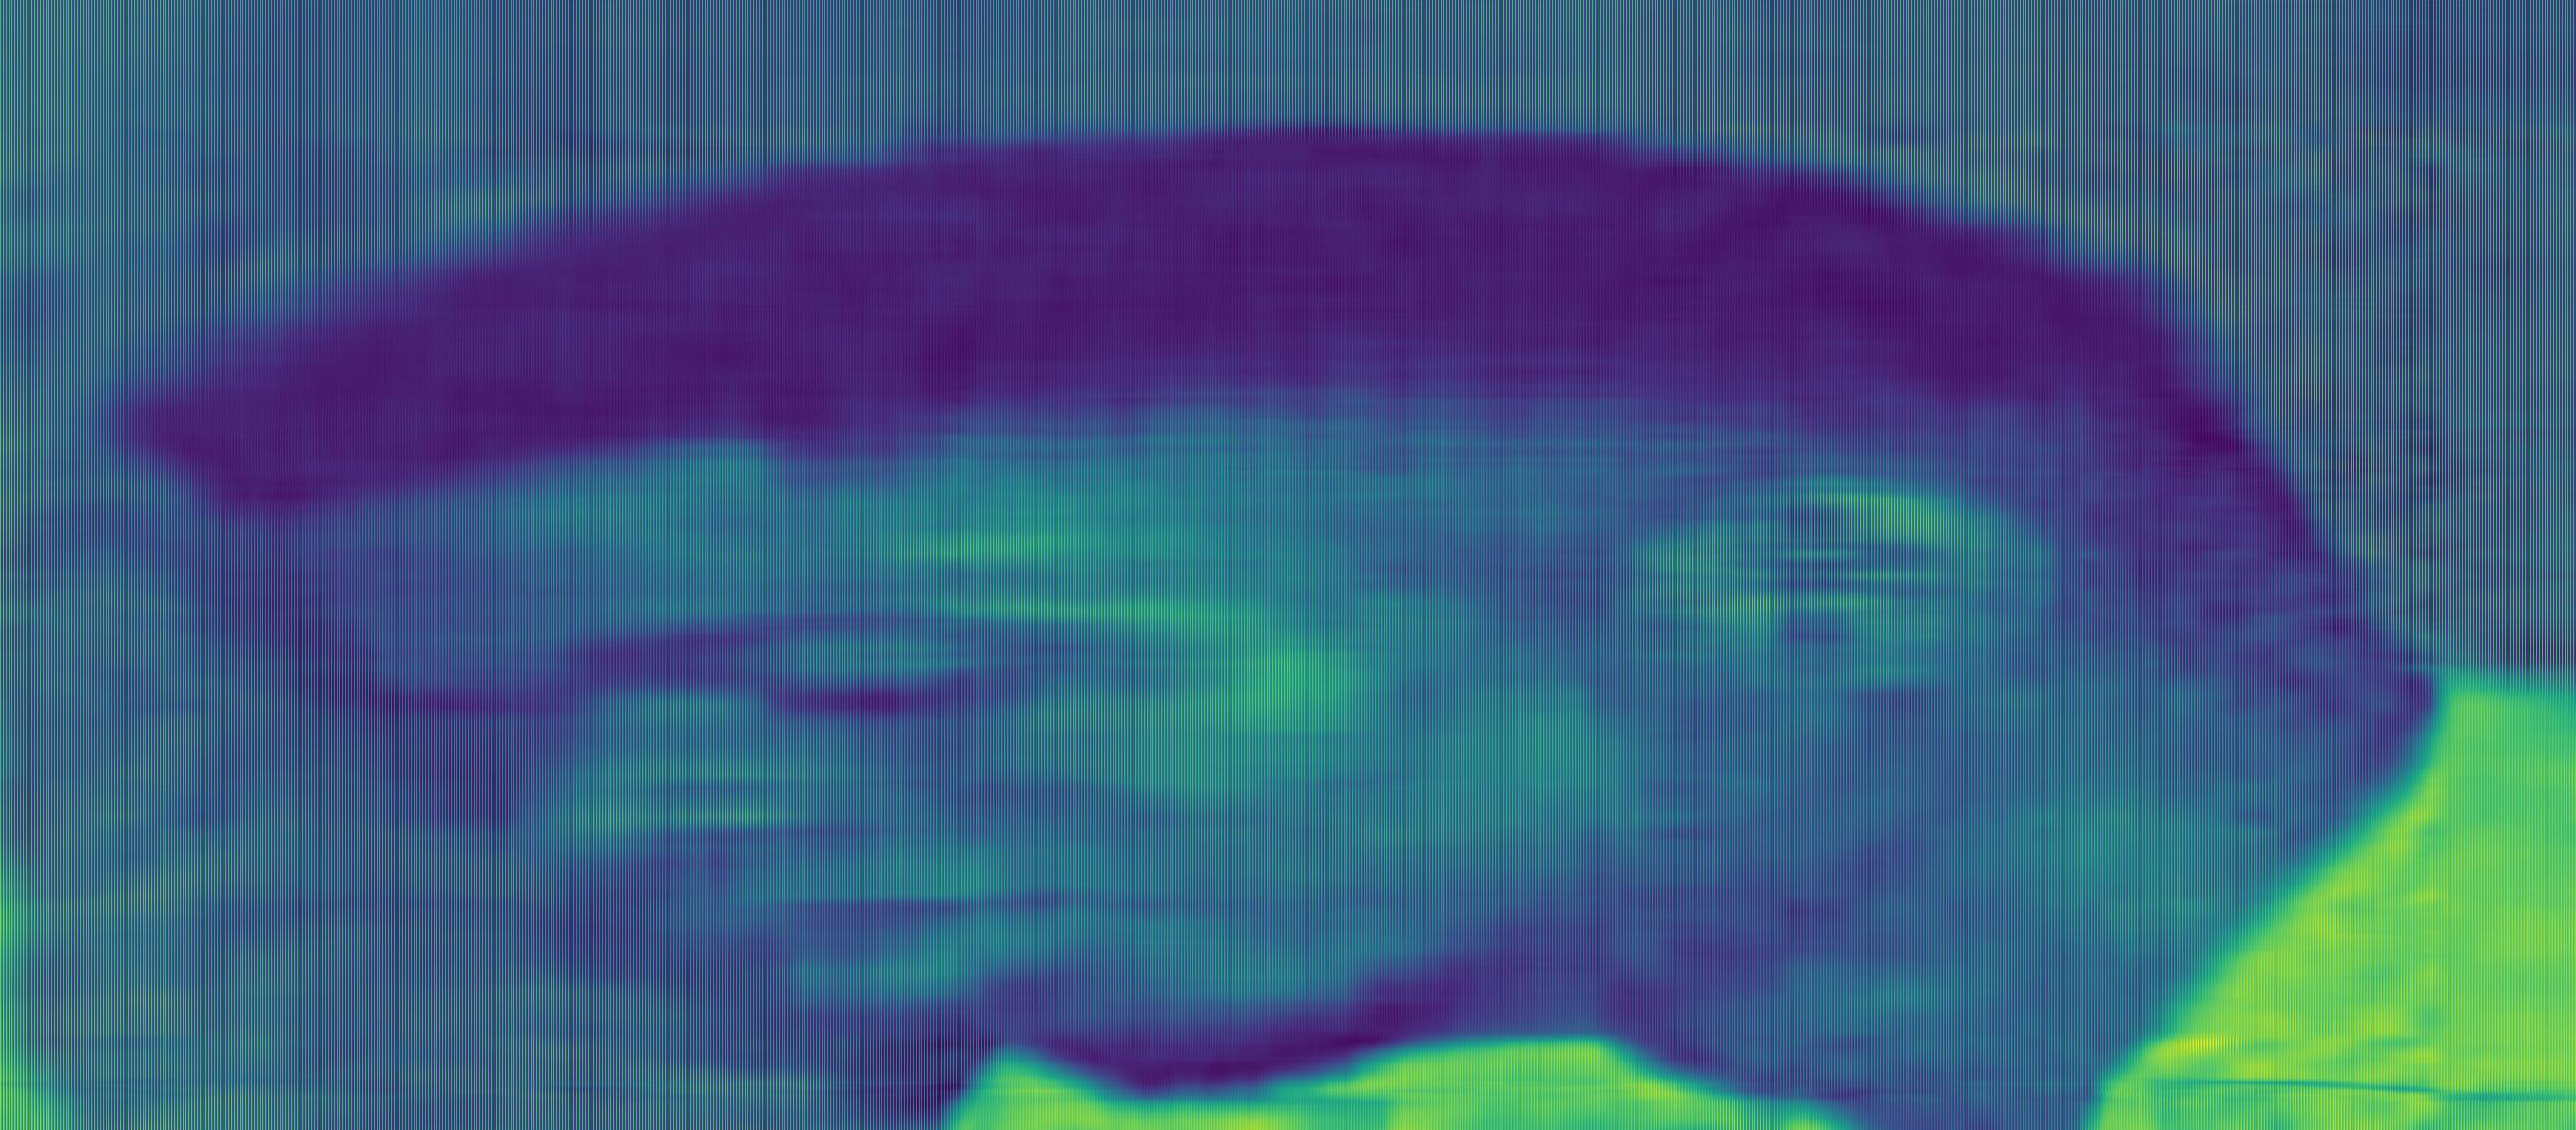

In [4]:
im = Image.open('compressed_inp/A2.jpg')

im

In [6]:
# Function to retrieve and standardize phases

def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    
    return face_array

In [25]:
# Function to retrieve faces

def load_faces(subject):
    faces = list()
    folder = 'training_set/'

    for filename in listdir(folder):
        # if filename.startswith(subject):
        path = folder + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [26]:
def load_dataset():
    subjects = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3']

    X_train, y_train, X_test, y_test = list(), list(), list(), list()
    count = 0

    for subject in subjects:
        faces = load_faces(subject)
        print("faces:",faces)
        labels = [subject for _ in range(len(faces))]
        print('>Loaded %d examples for class: %s' % (len(faces), subject))

        X_train.extend(faces[:3])
        y_train.extend(labels[:3])

        X_test.extend(faces[3:])
        y_test.extend(labels[3:])
        
    return asarray(X_train), asarray(y_train), asarray(X_test), asarray(y_test)

In [28]:
# train dataset

trainX, trainy, testX, testy = load_dataset()
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

# save arrays to one file in compressed format
savez_compressed('faces-dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 380ms/step
faces: [array([[[ 38,  32,  32],
        [ 44,  35,  36],
        [ 47,  40,  38],
        ...,
        [105,  74,  64],
        [ 98,  70,  59],
        [ 96,  73,  61]],

       [[ 48,  39,  40],
        [ 54,  46,  47],
        [ 50,  46,  43],
        ...,
        [109,  84,  73],
        [112,  86,  71],
        [106,  78,  59]],

       [[ 41,  37,  34],
        [ 52,  48,  46],
        [ 40,  39,  35],
        ...,
        [ 88,  64,  56],
        [ 88,  67,  51],
        [114,  84,  63]],

       ...,

       [[188, 181, 163],
        [187, 180, 162],
        [186, 180, 162],
        ...,
        [ 75,  53,  49],
        [ 76,  55,  50],
        [ 76,  57,  50]],

       [[188, 180, 161],
        [188, 180, 161],
        [187, 180, 161],
        ...,
        [ 80,  56,  51],
        [ 86,  63,  57],
        [ 81,  59,  54]],

       [[187, 179, 161],
        [188, 179, 162],
        [189, 180, 163],
        ...,
        [ 83,

c:\Users\manny-uncharted\Envs\facial-mesh-algo\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\manny-uncharted\Envs\facial-mesh-algo\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\manny-uncharted\Envs\facial-mesh-algo\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\manny-uncharted\Envs\facial-mesh-algo\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

In [29]:
# Show the dataset
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)

NameError: name 'trainX' is not defined

In [ ]:
# embedding the faces
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [ ]:
# Saving the arrys to a compressed file

data = load('faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
newTrainX = list()

for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
newTestX = list()

for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

savez_compressed('faces-embeddings.npz', newTrainX, trainy, newTestX, testy)